**Please run required sections of notebook as necessary.**

In [1]:
#uncomment all lines below in this cell to replicate my installation on colab

#!pip install qeds fiona geopandas xgboost gensim folium pyLDAvis descartes psaw pyarrow

#!apt-get install libproj-dev proj-data proj-bin  
#!apt-get install libgeos-dev  
#!pip install cython  
#!pip install cartopy 

## Install proj and geos using brew
#!brew install proj geos
## If shapely is already installed, first uninstall it
#!pip3 uninstall shapely
## Install the cython, numpy, pyshp, and six dependencies using pip
#!pip3 install --upgrade cython numpy pyshp six
## Install shapely from source with pip (the binary may not be linked to the correct version of geos
#!pip3 install shapely --no-binary shapely
## Finally, install cartopy using pip. The version on pypi does not yet work with the most recent
## release of proj, so instead install cartopy from source using the most recent version on github
#!pip3 install git+https://github.com/SciTools/cartopy.git --no-binary cartopy

In [2]:
import pandas as pd 
import os
import IPython

import json
with open("to_from_data.json", "r") as read_file:
    rankings = json.load(read_file)
data = pd.DataFrame(rankings)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import qeds
qeds.themes.mpl_style();

import cartopy.crs as ccrs #cartopy documentation: https://scitools.org.uk/cartopy/docs/latest/
import cartopy.feature as cfeature

#import geopandas as gpd
#from shapely.geometry import Point

In [4]:
inst_data = pd.read_json("to_from_data.json") #set directory as necessary

In [5]:
inst_data #same as data ^

,aid,to_institution_id,to_name,to_oid,startdate,to_latitude,to_longitude,to_rank,recruiter_type,description,from_oid,from_institution_id,latitude,longitude,from_institution_name,category_id,name,rank
0,2121,535,Tsinghua University,623,2010-01-01,39.999567,116.331991,86.0,1,Academic organization (economics department),186,2,42.273857,-83.737582,University of Michigan,1,Development; Growth,14.0
1,3816,2205,Amherst College,3503,2010-01-01,42.370910,-72.517003,NaN,1,Academic organization (economics department),186,2,42.273857,-83.737582,University of Michigan,1,Development; Growth,14.0
2,4160,1489,International Food Policy Research Institute (...,2600,2006-01-01,38.901517,-77.028317,NaN,7,Private (non-profit) business or organization,186,2,42.273857,-83.737582,University of Michigan,1,Development; Growth,14.0
3,4160,270,Colby College,316,2003-01-01,44.563869,-69.662636,NaN,1,Academic organization (economics department),186,2,42.273857,-83.737582,University of Michigan,1,Development; Growth,14.0
4,7484,13,University of Maryland,20,2011-08-01,38.984795,-76.944012,24.0,1,Academic organization (economics department),186,2,42.273857,-83.737582,University of Michigan,1,Development; Growth,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4883,43362,303,Temple University,2006,2019-07-01,NaN,NaN,NaN,2,Academic organization (business school),3209,17,NaN,NaN,Duke University,34,Statistics,NaN
4884,43445,742,New York University,881,2019-09-01,40.729055,-73.996523,NaN,1,Academic organization (economics department),3284,915,NaN,NaN,University of Tokyo,34,Statistics,NaN
4885,44214,22,Columbia University,29,2014-07-01,40.807715,-73.959602,10.0,1,Academic organization (economics department),2471,255,NaN,NaN,University of Zurich (Universität Zürich),34,Statistics,NaN
4886,44214,22,Columbia University,1164,2015-07-01,40.808962,-73.961354,10.0,2,Academic organization (business school),2471,255,NaN,NaN,University of Zurich (Universität Zürich),34,Statistics,NaN


In [6]:
inst_data = inst_data.dropna(subset = ["to_latitude", "to_longitude", "latitude", "longitude"]) #drop observations with missing geocoordinates

In [7]:
inst_data["startdate"] = pd.to_datetime(inst_data["startdate"]) #convert object to datetime

inst_data = inst_data[inst_data["startdate"].dt.year == 2019] #select rows with start date in year 2019

/home/peters/anaconda3/envs/sage/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
inst_data.name.unique().shape #note 33 unique categories, names

(31,)

In [9]:
inst_data.description.unique() #note 10 unique recruiter_types, descriptions

array(['Academic organization (economics department)',
       'Other type of organization',
       'Private (for profit) business or organization',
       'Government agency or commission',
       'Academic organization (other than econ, business, or ag econ)',
       'Academic organization (business school)',
       'Academic organization (agricultural/resource economics department)',
       'Private (non-profit) business or organization'], dtype=object)

In [10]:
import nltk
nltk.download("punkt")

def desc_reviser(string):
    string = string.lower()
    tokens = [i for i in nltk.tokenize.word_tokenize(string)]
    return(tokens)

#desc_reviser(inst_data.description[6])

[nltk_data] Downloading package punkt to /home/peters/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
desc_tokens = [desc_reviser(i) for i in inst_data.description]
inst_data["desc_tokens"] = desc_tokens

In [12]:
inst_data["revised_description"] = 0

for i in inst_data.index:
    if "academic" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = inst_data.description[i]
        
    elif "government" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = inst_data.description[i]
        
    elif "private" or "other" in inst_data.desc_tokens[i]:
        inst_data.revised_description[i] = "Private business or organization; Other type of organization"
        
    else: inst_data["revised_description"][i] = np.nan

/home/peters/anaconda3/envs/sage/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/peters/anaconda3/envs/sage/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/peters/anaconda3/envs/sage/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [13]:
inst_data[inst_data["description"] == "Other type of organization"]

,aid,to_institution_id,to_name,to_oid,startdate,to_latitude,to_longitude,to_rank,recruiter_type,description,from_oid,from_institution_id,latitude,longitude,from_institution_name,category_id,name,rank,desc_tokens,revised_description
36,42385,225,International Monetary Fund (IMF),1170,2019-07-01,0.000000,0.000000,NaN,8,Other type of organization,186,2,42.273857,-83.737582,University of Michigan,1,Development; Growth,14.0,"[other, type, of, organization]",Private business or organization; Other type o...
227,41455,424,World Bank,1244,2019-07-01,52.500904,13.412925,NaN,8,Other type of organization,24,17,36.001426,-78.938229,Duke University,1,Development; Growth,15.0,"[other, type, of, organization]",Private business or organization; Other type o...
298,42887,225,International Monetary Fund (IMF),1170,2019-07-01,0.000000,0.000000,NaN,8,Other type of organization,40,32,43.666021,-79.399823,University of Toronto,1,Development; Growth,19.0,"[other, type, of, organization]",Private business or organization; Other type o...
326,41261,424,World Bank,1244,2019-07-01,52.500904,13.412925,NaN,8,Other type of organization,80,433,59.362174,18.057831,Stockholm University,1,Development; Growth,71.0,"[other, type, of, organization]",Private business or organization; Other type o...
338,44282,424,World Bank,1244,2019-11-01,52.500904,13.412925,NaN,8,Other type of organization,86,74,40.423694,-86.911058,Purdue University,1,Development; Growth,93.0,"[other, type, of, organization]",Private business or organization; Other type o...
346,42828,424,World Bank,1244,2019-07-01,52.500904,13.412925,NaN,8,Other type of organization,92,78,37.428481,-122.165836,Stanford University,1,Development; Growth,3.0,"[other, type, of, organization]",Private business or organization; Other type o...
372,42681,424,World Bank,1244,2019-07-01,52.500904,13.412925,NaN,8,Other type of organization,235,90,51.526067,-0.133295,University College London,1,Development; Growth,16.0,"[other, type, of, organization]",Private business or organization; Other type o...
374,41221,225,International Monetary Fund (IMF),1170,2019-06-01,0.000000,0.000000,NaN,8,Other type of organization,235,90,51.526067,-0.133295,University College London,2,Econometrics,16.0,"[other, type, of, organization]",Private business or organization; Other type o...
578,42848,86,Toulouse School of Economics,203,2019-01-01,43.606772,1.437112,21.0,8,Other type of organization,336,290,41.313892,-72.924035,Yale University,2,Econometrics,11.0,"[other, type, of, organization]",Private business or organization; Other type o...
613,43392,424,World Bank,1244,2019-07-01,52.500904,13.412925,NaN,8,Other type of organization,361,311,42.360625,-71.083557,Massachusetts Institute of Technology,1,Development; Growth,7.0,"[other, type, of, organization]",Private business or organization; Other type o...


In [14]:
inst_data[inst_data["description"] == "Academic organization (other than econ, business, or ag econ)"] #check to ensure conditional in correct order - notice word "other"

,aid,to_institution_id,to_name,to_oid,startdate,to_latitude,to_longitude,to_rank,recruiter_type,description,from_oid,from_institution_id,latitude,longitude,from_institution_name,category_id,name,rank,desc_tokens,revised_description
290,41869,766,Korea Development Institute (KDI),1051,2019-07-01,36.481403,127.309839,NaN,4,"Academic organization (other than econ, busine...",37,29,42.350911,-71.105495,Boston University,1,Development; Growth,30.0,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."
470,33342,184,Behavior and Inequality Research Institute (briq),1204,2019-01-01,50.730250,7.109999,22.0,4,"Academic organization (other than econ, busine...",217,186,51.757409,-1.246866,University of Oxford,1,Development; Growth,8.0,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."
505,42082,186,University of Oxford,693,2019-07-01,51.752721,-1.262431,8.0,4,"Academic organization (other than econ, busine...",217,186,51.757409,-1.246866,University of Oxford,2,Econometrics,8.0,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."
851,40905,378,Nazarbayev University,619,2019-07-01,51.090530,71.398165,NaN,4,"Academic organization (other than econ, busine...",1326,1078,50.874810,4.700209,Katholieke Universiteit Leuven (KU Leuven),1,Development; Growth,NaN,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."
866,41937,78,Stanford University,1167,2019-07-01,37.427370,-122.164862,3.0,4,"Academic organization (other than econ, busine...",1015,622,40.104167,-88.223861,University of Illinois at Urbana-Champaign,1,Development; Growth,NaN,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."
1034,41235,990,London School of Economics and Political Science,1212,2019-07-01,51.514408,-0.117377,NaN,4,"Academic organization (other than econ, busine...",466,401,33.753068,-84.385282,Georgia State University,4,Environmental; Ag. Econ.,NaN,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."
1056,41862,144,New York University,1089,2019-07-01,40.730537,-73.999499,9.0,4,"Academic organization (other than econ, busine...",73,832,40.008170,-105.273582,"University of Colorado, Boulder",4,Environmental; Ag. Econ.,NaN,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."
1428,42390,6,University of California Los Angeles (UCLA),1352,2019-09-01,34.074402,-118.439087,20.0,4,"Academic organization (other than econ, busine...",70,59,50.844877,5.684819,Maastricht University,6,Finance,46.0,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."
1664,42919,370,Arizona State University,432,2019-07-01,33.416602,-111.934182,72.0,4,"Academic organization (other than econ, busine...",394,339,41.789922,-87.597338,University of Chicago,6,Finance,2.0,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."
1668,41168,78,Stanford University,130,2019-07-01,37.429248,-122.165263,3.0,4,"Academic organization (other than econ, busine...",394,339,41.789922,-87.597338,University of Chicago,7,Industrial Organization,2.0,"[academic, organization, (, other, than, econ,...","Academic organization (other than econ, busine..."


In [15]:
inst_data['revised_recruiter_hash'] = inst_data.revised_description.map(hash) #create column of revised recruiter types

In [16]:
inst_data.name.unique()

array(['Development; Growth', 'Econometrics', 'Environmental; Ag. Econ.',
       'Economic History', 'Experimental Economics', 'Finance',
       'Industrial Organization', 'International Finance/Macro',
       'International Trade', 'Labor; Demographic Economics',
       'Macroeconomics; Monetary', 'Law and Economics', 'Microeconomics',
       'Public Economics', 'Health; Education; Welfare', 'Theory',
       'Behavioral Economics', 'Urban; Rural; Regional Economics',
       'Any field', 'Other', 'Political Economy', 'Management, General',
       'Business Economics', 'Real Estate', 'Organizational Behavior',
       'Accounting', 'Computational Economics', 'Decision Sciences',
       'Insurance', 'Marketing', 'Statistics'], dtype=object)

In [17]:
inst_data = inst_data.loc[inst_data["name"].isin(["Development; Growth", "Microeconomics", "Macroeconomics; Monetary", "Econometrics", "Political Economy", "Theory", "Behavioral Economics", "Finance", "Industrial Organization", "Labor"])] #restrict analysis to fields with informative maps

In [18]:
inst_data["rank"].unique()#.shape

array([ 14.,  20.,  15.,  12.,  66.,  10.,  30.,  19.,  73.,  47.,  71.,
        84.,  31.,  93.,   3.,  21.,  16.,  69.,  77.,  42.,  79.,   6.,
         9.,  35.,   8.,  25.,  11.,   4.,   7.,   2.,  88.,   1.,   5.,
        60.,  32.,  13.,  40.,  64.,  nan,  24.,  46.,  51.,  72.,  23.,
       100.,  38.,  53.,  41.])

In [19]:
inst_data["from_coordinates"] = list(zip(inst_data.longitude, inst_data.latitude))
inst_data["to_coordinates"] = list(zip(inst_data.to_longitude, inst_data.to_latitude))

In [20]:
#before dropping NaN and restricting analysis
inst_data.category_id.unique() #no category 28?
#inst_data[inst_data.category_id == 28]

array([ 1,  2,  6,  7, 12, 13, 15, 16, 23])

In [21]:
data_subsets = {}
for i in inst_data.category_id.unique():
    inst_data_subset_iteration = inst_data[inst_data.category_id == i]
    data_subsets[i] = inst_data_subset_iteration

## Maps by Applicant Primary Field (Names) - using scatter-plot arrow proxy

In [22]:
#note that points converging at Gulf of Guinea are at intersection of Equator and Prime Meridian

#NaN probably coded as (0, 0) - dropped na above

#FIXME some institutions such as IMF, CBO, BEA coded as (0, 0) for example uncomment and run the next line
#inst_data.loc[inst_data["to_latitude"] == 0]

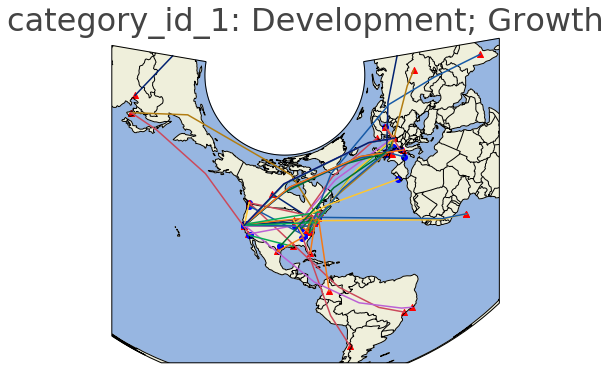

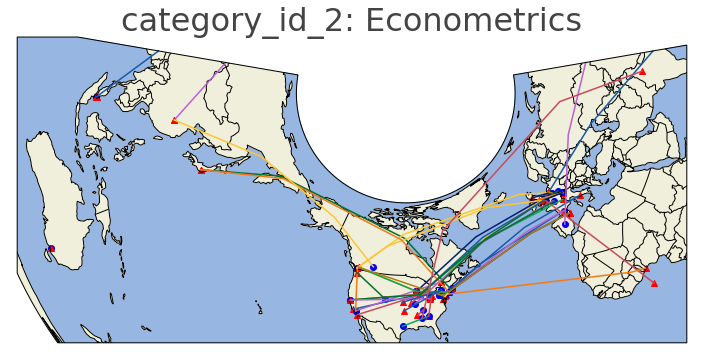

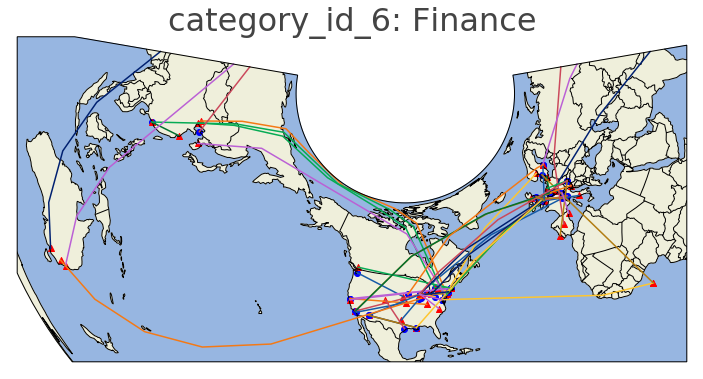

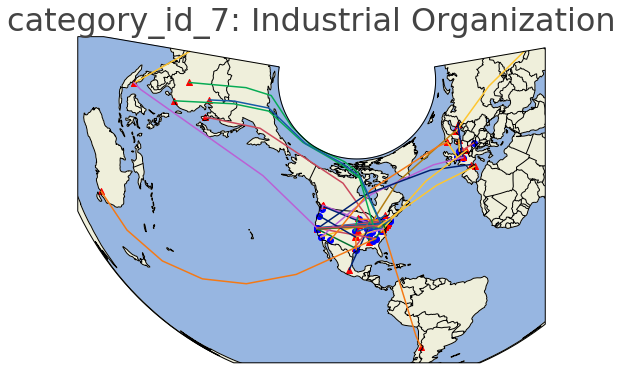

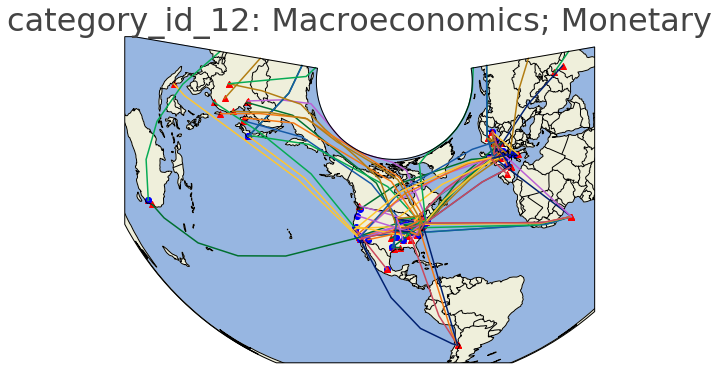

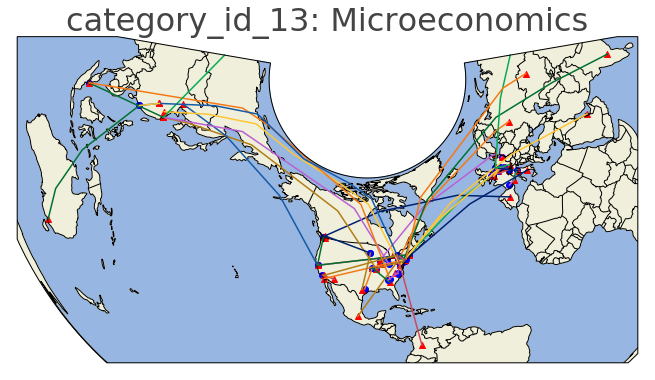

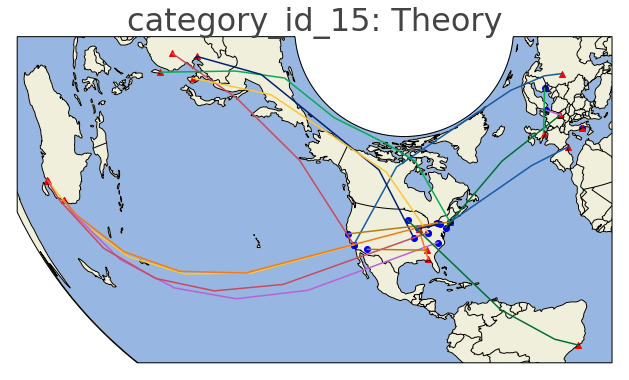

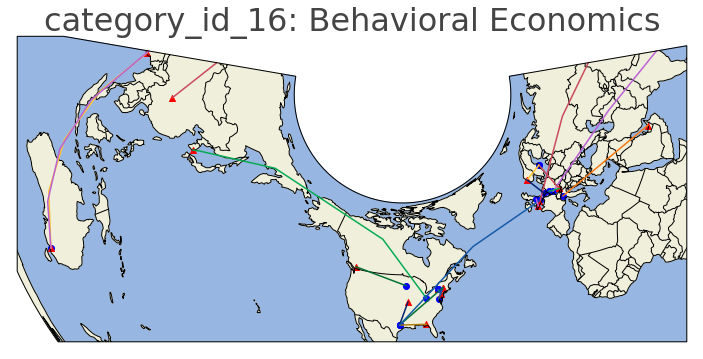

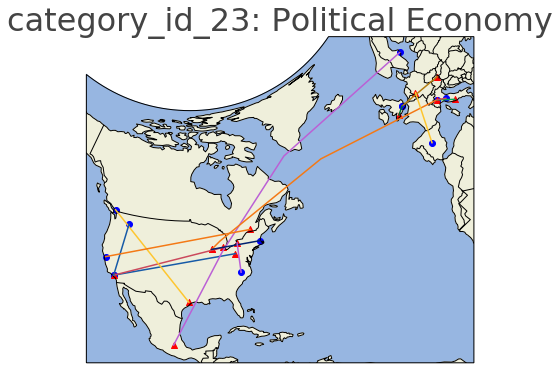

In [23]:
central_lat = 37.5
central_lon = -96
extent = [-120, -70, 24, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

#for j in inst_data.category_id.unique():
for j in {1,2,6,7,12,13,15,16,23}:
    fig = plt.figure(figsize=(12, 6)) #revised from (25, 20)
    #ax = fig.add_subplot(projection = ccrs.PlateCarree()) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    #
    ax = plt.axes(projection = ccrs.AlbersEqualArea(central_lon, central_lat), label =  'map' + str(j))
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0], fontsize = 32) #added fontsize
    
    for i in data_subsets[j].index:
        ax.scatter(inst_data.longitude[i], inst_data.latitude[i], transform = ccrs.Geodetic(), color = "blue", marker = "o") #use scatter point method from maps emailed
        ax.plot([inst_data.longitude[i], inst_data.to_longitude[i]], [inst_data.latitude[i], inst_data.to_latitude[i]], transform=ccrs.Geodetic())
        ax.scatter(inst_data.to_longitude[i], inst_data.to_latitude[i], transform = ccrs.Geodetic(), color = "red", marker = "^") #use scatter point method from maps emailed, ideally cartopy adaptation of basemap https://stackoverflow.com/questions/45512429/python-basemap-drawgreatcircle-with-arrow-end-cap?rq=1

    ax

## Maps by Applicant Primary Field (Names) - using annotation arrow proxy

In [24]:
#with arrows but not great circle plot

for j in inst_data.category_id.unique():
    fig = plt.figure(figsize=(80, 80)) #revised from (25, 20)
    ax = fig.add_subplot(projection = ccrs.Mercator()) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html

    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0], fontsize = 32) #added fontsize
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    for i in data_subsets[j].index:
        ax.annotate(" ", xy = (inst_data.to_longitude[i], inst_data.to_latitude[i]), xytext = (inst_data.longitude[i], inst_data.latitude[i]), arrowprops = dict(arrowstyle = "->", connectionstyle="arc3, rad = -0.8", color = "red"), xycoords = transform, ha = 'right', va = 'top', annotation_clip = False)



AttributeError: 'NoneType' object has no attribute 'coastlines'

<Figure size 5760x5760 with 0 Axes>

## Maps by Recruiter Type and Applicant Primary Field 

In [ ]:
data_subsets[1][data_subsets[1].recruiter_type == 1]

In [ ]:
for j in inst_data.category_id.unique():
    for k in data_subsets[j].recruiter_type.unique():
        fig = plt.figure(figsize=(80, 80)) #revised from (25, 20)
        ax = fig.add_subplot(projection = ccrs.PlateCarree()) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    
        ax.coastlines()
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAND)
        ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0] + "; recruiter_type_" + str(k) + ": " + data_subsets[j][data_subsets[j].recruiter_type == k].description.unique()[0], fontsize = 32)
    
        for i in data_subsets[j][data_subsets[j].recruiter_type == k].index:
            ax.scatter(inst_data.longitude[i], inst_data.latitude[i], transform = ccrs.Geodetic(), color = "blue", marker = "o") #use scatter point method from maps emailed
            ax.plot([inst_data.longitude[i], inst_data.to_longitude[i]], [inst_data.latitude[i], inst_data.to_latitude[i]], transform=ccrs.Geodetic())
            ax.scatter(inst_data.to_longitude[i], inst_data.to_latitude[i], transform = ccrs.Geodetic(), color = "red", marker = "^") #use scatter point method from maps emailed, ideally cartopy adaptation of basemap https://stackoverflow.com/questions/45512429/python-basemap-drawgreatcircle-with-arrow-end-cap?rq=1
     

##  Interactive Map - no arrows

In [ ]:
import plotly.graph_objects as go

In [ ]:
from_location_data = pd.DataFrame(inst_data.loc[:, ["latitude", "longitude", "from_institution_name", "rank"]])
to_location_data = pd.DataFrame(inst_data.loc[:, ["to_latitude", "to_longitude", "to_name", "to_rank"]])
location_data_1 = from_location_data.rename(columns = {"from_institution_name": "institution_name"})
location_data_2 = to_location_data.rename(columns = {"to_latitude": "latitude", "to_longitude": "longitude", "to_name": "institution_name", "to_rank": "rank"})

location_data = pd.concat([location_data_1, location_data_2], ignore_index = True)
location_data = location_data.loc[:, ["latitude", "longitude", "institution_name", "rank"]]
location_data = location_data.drop_duplicates(ignore_index = True)

In [ ]:
location_data

In [ ]:
fig = go.Figure()

In [ ]:
fig.add_trace(go.Scattergeo(lon = location_data["longitude"], lat = location_data["latitude"], hoverinfo = "text", text = location_data.loc[:, ["institution_name", "rank"]], mode = "markers", marker = dict(size = 2, color = "rgb(255, 0, 0)", line = dict(width = 3, color = "rgba(68, 68, 68, 0)"))))

In [ ]:
for i in inst_data.index:
    fig.add_trace(go.Scattergeo(lon = [inst_data["longitude"][i], inst_data["to_longitude"][i]], lat = [inst_data["latitude"][i], inst_data["to_latitude"][i]], mode = "lines", line = dict(width = 1, color = "red")))
    
#opacity = float(df["count"][i]) / float(df["count"].max()) 

In [ ]:
fig.update_layout(
    title_text = "Interactive Map", showlegend = False, geo = dict(projection_type = "equirectangular", showland = True, landcolor = "rgb(243, 243, 243)", countrycolor = "rgb(204, 204, 204)",))

#to add markers https://plotly.com/python/marker-style/

#FIXME institution name and rank instead of lat, lon

## Ranking Scatterplot

In [ ]:
import seaborn as sns

In [ ]:
data_clean_rank = data.dropna(subset = ["rank", "to_rank"])

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
rank_scat = sns.regplot(x = "rank", y = "to_rank", data = data_clean_rank, ax = ax)
rank_scat.get_lines()[0].set_color("red")

## Maps by Applicant Primary Field (Names) - East to West: Red; West to East: Black - Great Circle Plots

In [ ]:
# note longitude 180 == -180 

In [ ]:
for j in inst_data.category_id.unique():
    proj1 = ccrs.PlateCarree()
    fig = plt.figure(figsize=(80, 80)) #revised from (25, 20)
    ax = fig.add_subplot(projection = proj1) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    
    #ax.set_global() #sets extent of map to be global, choose this to avoid indiscernible plot in terms of country, note lines close together now very small, comment for zoom default
    ax.set_extent([-168.084722, 66.618056, 7.208889, 72], crs = proj1) #sets extent of map to include continental north america and mainland europe using https://en.wikipedia.org/wiki/Lists_of_extreme_points 
    #westernmost longitude of continental north america, easternmost longitude of mainland europe, southernmost point of continental north america, northernmost point of continental north america
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0], fontsize = 32) #added fontsize
    
    for i in data_subsets[j].index:
        
        if inst_data.longitude[i] >= inst_data.to_longitude[i]:
            colors = "red"
        else: colors = "black"
        
        ax.plot([inst_data.longitude[i], inst_data.to_longitude[i]], [inst_data.latitude[i], inst_data.to_latitude[i]], transform=ccrs.Geodetic(), color = colors)
        

## B/W Maps by Applicant Primary Field (Names) - East to West: Red; West to East: Blue - Great Circle Plots

In [ ]:
for j in inst_data.category_id.unique():
    proj1 = ccrs.PlateCarree()
    fig = plt.figure(figsize=(80, 80)) #revised from (25, 20)
    ax = fig.add_subplot(projection = proj1) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    
    #ax.set_global() #sets extent of map to be global, choose this to avoid indiscernible plot in terms of country, note lines close together now very small, comment for zoom default
    ax.set_extent([-168.084722, 66.618056, 7.208889, 72], crs = proj1) #sets extent of map to include continental north america and mainland europe using https://en.wikipedia.org/wiki/Lists_of_extreme_points 
    #westernmost longitude of continental north america, easternmost longitude of mainland europe, southernmost point of continental north america, northernmost point of continental north america
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0], fontsize = 32) #added fontsize
    
    for i in data_subsets[j].index:
        
        if inst_data.longitude[i] >= inst_data.to_longitude[i]:
            colors = "red"
        else: colors = "blue"
        
        ax.plot([inst_data.longitude[i], inst_data.to_longitude[i]], [inst_data.latitude[i], inst_data.to_latitude[i]], transform=ccrs.Geodetic(), color = colors)
        

## Maps by Applicant Primary Field (Names) - East to West: Red; West to East: Black - using annotation arrow proxy

In [ ]:
#with arrows but not great circle plot

for j in inst_data.category_id.unique():
    proj1 = ccrs.Mercator()
    fig = plt.figure(figsize=(80, 80)) #revised from (25, 20)
    ax = fig.add_subplot(projection = proj1) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    
    #ax.set_global() #sets extent of map to be global, choose this to avoid indiscernible plot in terms of country, note lines close together now very small, comment for zoom default
    ax.set_extent([-168.084722, 66.618056, 7.208889, 72], crs = proj1) #sets extent of map to include continental north america and mainland europe using https://en.wikipedia.org/wiki/Lists_of_extreme_points 
    #westernmost longitude of continental north america, easternmost longitude of mainland europe, southernmost point of continental north america, northernmost point of continental north america
    ax.coastlines()
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.LAND)
    ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0], fontsize = 32) #added fontsize
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    for i in data_subsets[j].index:
        
        if inst_data.longitude[i] >= inst_data.to_longitude[i]:
            colors = "red"
        else: colors = "black"
        
        ax.annotate(" ", xy = (inst_data.to_longitude[i], inst_data.to_latitude[i]), xytext = (inst_data.longitude[i], inst_data.latitude[i]), arrowprops = dict(arrowstyle = "->", connectionstyle="arc3, rad = -0.8", color = colors), xycoords = transform, ha = 'right', va = 'top', annotation_clip = False)



## B/W Maps by Applicant Primary Field (Names) - East to West: Red; West to East: Blue - using annotation arrow proxy

In [ ]:
#with arrows but not great circle plot

for j in inst_data.category_id.unique():
    proj1 = ccrs.Mercator()
    fig = plt.figure(figsize=(80, 80)) #revised from (25, 20)
    ax = fig.add_subplot(projection = proj1) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    
    #ax.set_global() #sets extent of map to be global, choose this to avoid indiscernible plot in terms of country, note lines close together now very small, comment for zoom default
    ax.set_extent([-168.084722, 66.618056, 7.208889, 72], crs = proj1) #sets extent of map to include continental north america and mainland europe using https://en.wikipedia.org/wiki/Lists_of_extreme_points 
    #westernmost longitude of continental north america, easternmost longitude of mainland europe, southernmost point of continental north america, northernmost point of continental north america
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0], fontsize = 32) #added fontsize
    transform = ccrs.PlateCarree()._as_mpl_transform(ax)
    for i in data_subsets[j].index:
        
        if inst_data.longitude[i] >= inst_data.to_longitude[i]:
            colors = "red"
        else: colors = "blue"
        
        ax.annotate(" ", xy = (inst_data.to_longitude[i], inst_data.to_latitude[i]), xytext = (inst_data.longitude[i], inst_data.latitude[i]), arrowprops = dict(arrowstyle = "->", connectionstyle="arc3, rad = -0.8", color = colors), xycoords = transform, ha = 'right', va = 'top', annotation_clip = False)


## Maps by Revised Recruiter Type and Applicant Primary Field

In [ ]:
for j in inst_data.category_id.unique():
    for k in data_subsets[j].revised_recruiter_hash.unique():
        proj1 = ccrs.PlateCarree()
        fig = plt.figure(figsize=(80, 80)) #revised from (25, 20)
        ax = fig.add_subplot(projection = proj1) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    
        #ax.set_global() #sets extent of map to be global, choose this to avoid indiscernible plot in terms of country, note lines close together now very small, comment for zoom default
        ax.set_extent([-168.084722, 66.618056, 7.208889, 72], crs = proj1) #sets extent of map to include continental north america and mainland europe using https://en.wikipedia.org/wiki/Lists_of_extreme_points 
        #westernmost longitude of continental north america, easternmost longitude of mainland europe, southernmost point of continental north america, northernmost point of continental north america
        ax.coastlines()
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAND)
        ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0] + "; revised_recruiter_hash_" + str(k) + ": " + data_subsets[j][data_subsets[j].revised_recruiter_hash == k].revised_description.unique()[0], fontsize = 32) #NOTE data_description_aa_dsouza has method description instead of revised_description, needs to be fixed there
    
        for i in data_subsets[j][data_subsets[j].revised_recruiter_hash == k].index:
            ax.scatter(inst_data.longitude[i], inst_data.latitude[i], transform = ccrs.Geodetic(), color = "blue", marker = "o") #use scatter point method from maps emailed
            ax.plot([inst_data.longitude[i], inst_data.to_longitude[i]], [inst_data.latitude[i], inst_data.to_latitude[i]], transform=ccrs.Geodetic())
            ax.scatter(inst_data.to_longitude[i], inst_data.to_latitude[i], transform = ccrs.Geodetic(), color = "red", marker = "^") #use scatter point method from maps emailed, ideally cartopy adaptation of basemap https://stackoverflow.com/questions/45512429/python-basemap-drawgreatcircle-with-arrow-end-cap?rq=1
     

## Maps by Revised Recruiter Type and Applicant Primary Field - East to West: Red; West to East: Black

In [ ]:
for j in inst_data.category_id.unique():
    for k in data_subsets[j].revised_recruiter_hash.unique():
        proj1 = ccrs.PlateCarree()
        fig = plt.figure(figsize=(80, 80)) #revised from (25, 20)
        ax = fig.add_subplot(projection = proj1) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    
        #ax.set_global() #sets extent of map to be global, choose this to avoid indiscernible plot in terms of country, note lines close together now very small, comment for zoom default
        ax.set_extent([-168.084722, 66.618056, 7.208889, 72], crs = proj1) #sets extent of map to include continental north america and mainland europe using https://en.wikipedia.org/wiki/Lists_of_extreme_points 
        #westernmost longitude of continental north america, easternmost longitude of mainland europe, southernmost point of continental north america, northernmost point of continental north america
        ax.coastlines()
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.LAND)
        ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0] + "; revised_recruiter_hash_" + str(k) + ": " + data_subsets[j][data_subsets[j].revised_recruiter_hash == k].revised_description.unique()[0], fontsize = 32) #NOTE data_description_aa_dsouza has method description instead of revised_description, needs to be fixed there
    
        for i in data_subsets[j][data_subsets[j].revised_recruiter_hash == k].index:
            
            if inst_data.longitude[i] >= inst_data.to_longitude[i]:
                colors = "red"
            else: colors = "black"
                
            ax.plot([inst_data.longitude[i], inst_data.to_longitude[i]], [inst_data.latitude[i], inst_data.to_latitude[i]], transform=ccrs.Geodetic(), color = colors)



## B/W Maps by Revised Recruiter Type and Applicant Primary Field - East to West: Red; West to East: Blue

In [ ]:
for j in inst_data.category_id.unique():
    for k in data_subsets[j].revised_recruiter_hash.unique():
        proj1 = ccrs.PlateCarree()
        fig = plt.figure(figsize=(80, 80)) #revised from (25, 20)
        ax = fig.add_subplot(projection = proj1) #Projection list: https://scitools.org.uk/cartopy/docs/latest/crs/projections.html
    
        #ax.set_global() #sets extent of map to be global, choose this to avoid indiscernible plot in terms of country, note lines close together now very small, comment for zoom default
        ax.set_extent([-168.084722, 66.618056, 7.208889, 72], crs = proj1) #sets extent of map to include continental north america and mainland europe using https://en.wikipedia.org/wiki/Lists_of_extreme_points 
        #westernmost longitude of continental north america, easternmost longitude of mainland europe, southernmost point of continental north america, northernmost point of continental north america
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.set_title("category_id_" + str(j) + ": " + data_subsets[j].name.unique()[0] + "; revised_recruiter_hash_" + str(k) + ": " + data_subsets[j][data_subsets[j].revised_recruiter_hash == k].revised_description.unique()[0], fontsize = 32) #NOTE data_description_aa_dsouza has method description instead of revised_description, needs to be fixed there
    
        for i in data_subsets[j][data_subsets[j].revised_recruiter_hash == k].index:
            
            if inst_data.longitude[i] >= inst_data.to_longitude[i]:
                colors = "red"
            else: colors = "blue"
                
            ax.plot([inst_data.longitude[i], inst_data.to_longitude[i]], [inst_data.latitude[i], inst_data.to_latitude[i]], transform=ccrs.Geodetic(), color = colors)

